*  DSC530-T302 Data Exploration and Analysis (2261-1)
*  Weeks 9 & 10 Coding Assignment
*  Hope Lopez

I am loading the libraries below for use throughout the various exercises for this assignment.

In [116]:
# loads the matplotlib.pyplot, seaborn, pandas & numpy libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import fowlkes_mallows_score, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from ml_utils.regression import plot_residuals
from sklearn.metrics import classification_report
from ml_utils.classification import plot_roc
from ml_utils.classification import confusion_matrix_visual
from sklearn.linear_model import LogisticRegression

# Chapter 9, Exercise 1: Clustering Model

**1.1. Combine the red and white wine datasets (data/winequality-red.csv and data/winequality-white.csv, respectively) and add a column for the kind of wine (red or white).**

I first took a look at the 2 .csv files, and noticed that the winequality-white.csv has all the data jumbled into one column, so when I loaded it into a pandas DataFrame (df) called 'white_wine' I added an argument to my pd.read_csv() function to seperate the data where there are semi-colons since it is not comma delimited. The red wine file (winequality-red.csv) did not have this issue so I loaded it in normally into a df called 'red_wine'. Then I produced a quick summaries for both datasets using the .info() function. From these summaries I was able to determine that there are no null values in either dataset and both datasets have the same columns (in the same ordere) and each pair of corresponding columns have the same datatype. After this initial assessment, I created a new df called 'wine_data' that combined the 2 datasets using the .concat() function and added a new column namned 'type' which indicates whether the wine is red or white. 

In [18]:
# creates a new DF called 'white_wine' to hold the winequality-white.csv data
white_wine = pd.read_csv('data/winequality-white.csv', sep = ';')
# generates a quick summary of the df for my reference 
white_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [19]:
# creates a new DF called 'red_wine' to hold the winequality-red.csv data
red_wine = pd.read_csv('data/winequality-red.csv')
# generates a quick summary of the df for my reference 
red_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [21]:
# combines the white_wine and red_wine data into a new df called 'wine_data'  
# & creates a column called 'type' which indicates red/white wine type
wine_data = pd.concat([white_wine.assign(type ='white'), red_wine.assign(type ='red')])
# displays wine_data info() to validate new column was created succesfully
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6497 entries, 0 to 1598
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type                  6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 710.6+ KB


**1.2. Build and fit a pipeline that scales the data and then uses k-means clustering to make two clusters. Be sure not to use the quality column.**

For the k-means clustering pipeline, I had to choose numeric features only, and the instructions state not to use the quality column. From my previous .info() I know all of my columns except for 'type' and 'quality' are float types, which are numeric. So, I dropped 'quality' and 'type' when defining the features set. I set the target variable as 'type' (red/white wine type indicator). Next, I split the data into training and test sets, allocating 25% of the data for the test set (the remaining 75% is allocated to the training set). I also ensured reproducibility by setting the random_states to zero, and used stratify = wtarget to preserve the proportion of red to white wines in both sets. Finally, I built the pipeline named 'kmeans_pipeline'. The pipeline first scaled the features using Standardscaler() so each feature got normalized to a mean of zero and a standard deviation (std.) of 1. Then, it applied KMeans() clustering to make 2 clusters, corresponding to the 2 wine types (red/white). I had to explicitly set n_init = 10 to supress FutureWarnings/future-proof consistent behavior for future scikit-learn versions. Finally, I fit the pipeline to the training features set using .fit(). 

In [26]:
# defines target variable,'type' 
wtarget = wine_data['type'] 
# defines features, specifically excluding 'quality' and 'type'
wfeatures = wine_data.drop(columns = ['quality', 'type'])

# splits the data into training & test sets
wfeatures_train, wfeatures_test, wtarget_train, wtarget_test = train_test_split(
    wfeatures, wtarget, 
    # allocates 25% of data to the test set & the rest (75%) to the training set
    test_size = 0.25, 
    # ensures reproducibility
    random_state = 0, 
    # ensures both sets preserve proportion of red/white wines
    stratify = wtarget
)

# builds a new pipeline named 'kmeans_pipeline'
kmeans_pipeline = Pipeline([
    # scales the features, so each feature is normalized (mean = 0 and std. = 1)
    ('scale', StandardScaler()), 
    # applies k-means clustering w/ 2 clusters
    ('kmeans', KMeans(n_clusters = 2, random_state = 0, n_init = 10))
# fits the pipeline on the training features set    
]).fit(wfeatures_train)

**1.3. Use the Fowlkes-Mallows Index (the fowlkes_mallows_score() function is in sklearn.metrics) to evaluate how well k-means is able to make the distinction between red and white wine.**

In [47]:
# gets predicted cluster labels from kmeans_pipeline
predicted = kmeans_pipeline.predict(wfeatures_test)
# displays the count of samples assigned to each cluster
print("Predicted cluster label distribution:")
print(pd.Series(predicted).value_counts())

# displays the actual distribution of wine types in the test set
print("\nActual wine type distribution:")
print(wtarget_test.value_counts())

Predicted cluster label distribution:
0    1211
1     414
Name: count, dtype: int64

Actual wine type distribution:
type
white    1225
red       400
Name: count, dtype: int64


In [48]:
# converts wtarget_test to numeric to get actual cluster labels from pipeline
actual = wtarget_test.map({'red': 1, 'white':0})

# computes the Fowlkes-Mallows Index using folks_mallows_score()
fmi = fowlkes_mallows_score(actual, predicted)
# prints the FMI in a readable format
print(f'Folks-Mallows Index: {fmi: 4f}')

Folks-Mallows Index:  0.982467


**1.4. Find the center of each cluster.**

Here, I've used .clusters_centers_ to get the scaled cluster centers, or centroids, from the Kmeans step of my pipeline. I then displayed these centroids using a transposed DataFrame, with features as rows and each cluster as a column. 

In [53]:
# gets the scaled cluster centers (centroids)
scaled_centroids = kmeans_pipeline.named_steps['kmeans'].cluster_centers_

# displays the scaled centroids
print('Scaled Centroids:')
print(pd.DataFrame(scaled_centroids, columns = wfeatures.columns).T)

Scaled Centroids:
                             0         1
fixed acidity        -0.275812  0.812249
volatile acidity     -0.399735  1.177196
citric acid           0.124769 -0.367437
residual sugar        0.213667 -0.629236
chlorides            -0.319244  0.940155
free sulfur dioxide   0.286527 -0.843805
total sulfur dioxide  0.404604 -1.191533
density              -0.225100  0.662905
pH                   -0.194324  0.572273
sulphates            -0.288139  0.848551
alcohol               0.023790 -0.070061


# Chapter 9, Exercise 2: Predict Star temperature

**2.1. Using the data/stars.csv file, perform some initial EDA and then build a linear regression model of all the numeric columns to predict the temperature of the star.**

I first loaded the stars.csv data into a pandas DataFrame (DF) named 'stars'. Then I produced a quick summary of the stars data using the .info() function. I noticed there was quite a lot of data missing across several columns, so I wanted to how my data changes without those null values. Since my focus for the linear regression model will be the numeric columns, I used .describe() to get an overview of some of the descriptive stats for the original numeric columns. Then, I dropped the na values for those same numeric columns of interest and then used .describe() again to compare the descriptive stats before and after dropping the na values. I was left with 596 rows, down from the original 3183, which is approximately 18% of the original dataset. Since I want to predict temperature, when setting up my linear regression model, I set the 'temperature' column as my target. 

In [70]:
# creates a new DF called 'stars' to hold the stars.csv data
stars = pd.read_csv('data/stars.csv')
# generates a quick summary of the df for my reference 
stars.info()
# checks missing (na) count by column
stars.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3183 entries, 0 to 3182
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   temperature   2793 non-null   float64
 1   magV          1274 non-null   float64
 2   mass          3090 non-null   float64
 3   spectraltype  1206 non-null   object 
 4   magJ          1563 non-null   float64
 5   radius        2721 non-null   float64
 6   magB          1003 non-null   float64
 7   magH          1556 non-null   float64
 8   magK          1585 non-null   float64
 9   metallicity   2411 non-null   float64
 10  name          3183 non-null   object 
 11  planets       3183 non-null   float64
dtypes: float64(10), object(2)
memory usage: 298.5+ KB


temperature      390
magV            1909
mass              93
spectraltype    1977
magJ            1620
radius           462
magB            2180
magH            1627
magK            1598
metallicity      772
name               0
planets            0
dtype: int64

In [55]:
# computes some descriptive stats for num. columns of interest
stars[['temperature', 'magV', 'mass', 'magJ', 'radius', 'magB', 'magH', 'magK', 'metallicity', 'planets']].describe()

,temperature,magV,mass,magJ,radius,magB,magH,magK,metallicity,planets
count,2793.000000,1274.000000,3090.000000,1563.000000,2721.000000,1003.000000,1556.000000,1585.000000,2411.000000,3183.000000
mean,5532.146084,10.304334,0.960175,9.899493,1.605091,10.730635,9.525366,9.408291,0.017893,1.273327
std,1715.076581,3.148937,0.362107,3.226399,3.689890,3.032962,3.253978,3.214560,0.183447,0.853176
min,485.000000,0.010000,0.010000,-1.150000,0.000014,0.720000,-1.380000,-1.490000,-2.090000,0.000000
25%,5078.000000,7.950000,0.807250,7.013500,0.812000,8.512500,6.664750,6.589000,-0.060000,1.000000
50%,5627.000000,10.471500,0.964000,10.600000,0.999000,10.810000,10.248500,10.161000,0.020000,1.000000
75%,5949.000000,12.543500,1.110000,12.607500,1.270000,13.010000,12.230250,12.119000,0.110000,1.000000
max,57000.000000,24.300000,4.500000,21.600000,83.800000,19.860000,20.800000,19.160000,0.560000,9.000000


In [73]:
# drops the null values from the columns of interest 
nonna_data = stars[['temperature', 'magV', 'mass', 'magJ', 'radius', 'magB', 'magH', 'magK', 'metallicity', 'planets']].dropna()
# computes descriptive stats from dataset w/o NAs
nonna_data.describe()

,temperature,magV,mass,magJ,radius,magB,magH,magK,metallicity,planets
count,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000
mean,5485.501533,9.752196,1.137591,8.256052,2.937254,10.528812,7.904433,7.784607,0.036371,1.323826
std,806.653805,3.007381,0.392616,2.981420,5.627927,3.030631,3.055997,3.034384,0.247051,0.868208
min,2904.000000,0.010000,0.089000,-1.150000,0.107000,0.720000,-1.380000,-1.490000,-2.090000,0.000000
25%,5001.500000,7.595000,0.924500,6.078250,0.930000,8.319750,5.743000,5.594750,-0.090000,1.000000
50%,5622.500000,9.775000,1.088500,7.850500,1.210000,10.450000,7.560000,7.486000,0.070000,1.000000
75%,5989.250000,12.057250,1.281250,10.675500,1.764250,12.742500,10.377250,10.299000,0.200000,1.000000
max,11327.000000,17.940000,3.090000,15.800000,51.100000,19.860000,20.214000,15.480000,0.560000,9.000000


In [76]:
# preparing data for linear regression modeling:

# defines the target as 'temperature' column
starget = nonna_data['temperature']
# defines the feature set, exlcluding 'temperature' col. 
sfeatures = nonna_data.drop(columns = 'temperature')

**2.2. Train the model on 75% of the initial data.**

For this step, I simply split the data, allocating 25% for the test set and the remaining 75% for the training set. After doing this I fit my linear regression model on the training features set. 

In [77]:
#splits the data into training and test sets
sfeatures_train, sfeatures_test, starget_train, starget_test = train_test_split(
    sfeatures, starget,
    # allocates 25% of data to the test set & the remaining 75% to the training set
    test_size=0.25,
    # ensures reproducibility
    random_state=0
)

# fits the model on the training features set  
lr_model = LinearRegression().fit(sfeatures_train, starget_train)

**2.3. Calculate the R2 and RMSE of the model.**

Below, I've used the sklearn.metrics functions r2_score() to calculate the R-squared (R2) value and the mean_squared_error function to calculate Root Mean Square Error (RMSE). These two metrics help to evaluate the performance of the linear refression model. The R-squared value of approx. 0.880218 indicates that roughly 88% of the variance in the target variable can be explained by the model. Suggesting that the model is a good fit since it captures most of the underlying patterns in the data. The Root Mean Square Error (RMSE), which measures the average magntude of prediction errors in the same units as the target variable came out to approx. 257.943819. To be able to interpret this value I generated the min., max., and mean of the starget_test data, and calculated the RMSE as a percentage of the mean, which resulted in 4.72%. This can be interpreted as, the RMSE represents just 4.72% of the mean, indicating that the model's predictions deviate only slightly from the actual values. This low relative error rate confirms that the model is performing well, with high accuracy and precision. 

In [83]:
# makes predictions from the test set
starget_prediction = lr_model.predict(sfeatures_test)

# calculates R2 score
r2 = r2_score(starget_test, starget_prediction)
# displays the R2 score, formatted and rounded to 6 dec. places for readability
print(f"R-Squared (R2): {r2: .6f}")

# calculates RMSE
rmse = np.sqrt(mean_squared_error(starget_test, starget_prediction))
# displays the RMSE, formatted and rounded to 6 dec. places for readability
print(f"Root Mean Square Error (RMSE): {rmse: .6f}")

R-Squared (R2):  0.880218
Root Mean Square Error (RMSE):  257.943819


In [106]:
# descripive stats of starget_test
print("Min:", starget_test.min())
print("Max:", starget_test.max())
print("Mean:", starget_test.mean())
# calculates the RMSE % of mean to assess whether the RMSE is acceptable
rmse_pct = (rmse / starget_test.mean()) * 100
# displays RMSE as a percentage of the mean (rounded to 2 dec. places)
print(f"RMSE as % of mean: {rmse_pct:.2f}%")

Min: 2904.0
Max: 7598.0
Mean: 5468.314765100671
RMSE as % of mean: 4.72%


**2.4. Find the coefficients for each regressor and the intercept of the linear regression equation.**

Below, I've displayed the coefficients for each regressor and the intercept of the fitted equation. These values help define the linear relationship between the features and the predicted target variable, temperature. Each coefficient represents the expected change in the target variable temperature for a 1 unit increase in the corresponding feature, while all other features are constant. For example, from the results below, a 1-unit increase in magK is associated with an increase of approx. 1531.793875 in the predicted temperature. While the intercept (approx. 6646.673348) is the predicted temperature when all feature values are zero. When we look at these metrics together, they can provide insights into how each feature influences the model's predictions. 

In [89]:
# gets the coefficients for each regressor
coefficients = pd.Series(lr_model.coef_, index = sfeatures.columns)
# displays the coefficients
print(f'Model Regressor Coefficients:\n\n{coefficients}')

Model Regressor Coefficients:

magV           -174.252830
mass            276.081089
magJ           -990.333226
radius            4.455241
magB           -328.057437
magH             -6.003847
magK           1531.793875
metallicity      -5.045911
planets         -29.173599
dtype: float64


In [91]:
print(f'Intercept of Linear Regression Equation: {lr_model.intercept_}')

Intercept of Linear Regression Equation: 6646.673347525051


**2.5. Visualize the residuals using the plot_residuals() function from the ml_utils.regression module.**

I've leveraged the plot_residuals() function from the ml_utils.regression module to visualize the residuals. This function generated two plots that helped me to visually check the performance of the linear regression model. The first/left plot is a scatter plot of residuals vs. observation index, showing how prediction errors vary across the test samples. Most of the residuals are centered around 0, suggesting that the model generally performs well. However, there are some visible outliers with residuals outside of the -500/+500 range. This suggests that the model significantly underpredicted temperature for those specific observations. The second/right plot is a density plot of the residuals. The distribution appears to be roughly symmetric and centered near zero, which supports the required assumption for linear regression of normally distributed errors. However, the distribution is slightly right-skewed, with a longer positve tail, indicating the model tends to underpredict temperature more often than it overpredicts. The residuals span a wide range which reinforces the observation that a few predictions deviate substantially from the actual values. Together, these plots provide a comprehensive overview of the model's performance. The residuals are mostly well-behaved however, the presence of large outliers and mild skewness suggest areas for improvement. 

array([<Axes: xlabel='Observation', ylabel='Residual'>,
       <Axes: xlabel='Residual', ylabel='Density'>], dtype=object)

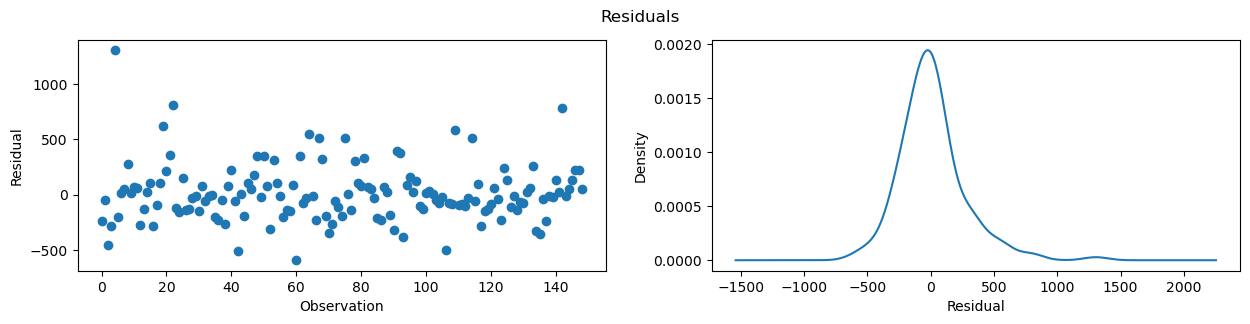

In [101]:
# plots the residuals using 
plot_residuals(starget_test, lr_model.predict(sfeatures_test))

# Chapter 9, Exercise 3: Classify Planets That Have Shorter Years Than Earth

**3.1. Using the data/planets.csv file, build a logistic regression model with the eccentricity, semimajoraxis, and mass columns as regressors. You will need to make a new column to use for the y (year shorter than Earth).**

To begin, I first loaded the planets.csv data into a pandas DataFrame (DF) named 'planets'. Then I produced a quick summary of the planets data using the .info() function and .isna().sum(). I noticed there was quite a lot of data missing across several columns, so I wanted to how my data changes without those null values. Since my focus for the linear regression model will be the  eccentricity, semimajoraxis, and mass columns, I used .describe() to get an overview of some of the descriptive stats for the original columns. Then, I dropped the na values for those same columns of interest and then used .describe() again to compare the descriptive stats before and after dropping the na values. I was left with 1,234 rows, down from the original 4,094, which is approximately 30% of the original dataset. Since I want to predict planets that have shorter years than earth, I had to create a new column 'yr_shorterthan_earth' which is a boolean type, that indicates True if the planet has a shorter year than earth, or false if not. After completing this preperation, I then created the logistic regression model using LogisticRegression(), with the  'yr_shorterthan_earth' as the target, and eccentricity, semimajoraxis, and mass columns as the regressors. I split the data using train_test_split(), allocating 25% to the test set and the remaining 75% to the training set. I also stratified by the target to preserve the proportion of planets with shorter/longer years than Earth. Finally, fit the model on the training data. 

In [121]:
# creates a new DF called 'planets' to hold the planets.csv data
planets = pd.read_csv('data/planets.csv')
# generates a quick summary of the df for my reference 
planets.info()
# checks missing (na) count by column
planets.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4094 entries, 0 to 4093
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mass             1659 non-null   float64
 1   description      3709 non-null   object 
 2   periastrontime   203 non-null    float64
 3   semimajoraxis    1704 non-null   float64
 4   discoveryyear    4083 non-null   float64
 5   list             4094 non-null   object 
 6   eccentricity     1388 non-null   float64
 7   period           3930 non-null   float64
 8   discoverymethod  4046 non-null   object 
 9   lastupdate       4087 non-null   object 
 10  periastron       561 non-null    float64
 11  name             4094 non-null   object 
dtypes: float64(7), object(5)
memory usage: 383.9+ KB


mass               2435
description         385
periastrontime     3891
semimajoraxis      2390
discoveryyear        11
list                  0
eccentricity       2706
period              164
discoverymethod      48
lastupdate            7
periastron         3533
name                  0
dtype: int64

In [108]:
# computes some descriptive stats for columns of interest
planets[['eccentricity', 'semimajoraxis', 'mass']].describe()

,eccentricity,semimajoraxis,mass
count,1388.000000,1704.000000,1659.000000
mean,0.159016,5.837964,2.702061
std,0.185041,110.668743,8.526177
min,0.000000,0.004420,0.000008
25%,0.013000,0.051575,0.085000
50%,0.100000,0.140900,0.830000
75%,0.230000,1.190000,2.440000
max,0.956000,3500.000000,263.000000


In [110]:
# drops the null values from the columns of interest 
nonna_planets = planets[['eccentricity', 'semimajoraxis', 'mass']].dropna()
# computes descriptive stats from dataset w/o NAs
nonna_planets.describe()

,eccentricity,semimajoraxis,mass
count,1234.000000,1234.000000,1234.000000
mean,0.163909,1.430026,2.761180
std,0.189077,4.295767,9.384857
min,0.000000,0.009160,0.000008
25%,0.011000,0.054000,0.150075
50%,0.100000,0.237150,0.918500
75%,0.240000,1.486750,2.482750
max,0.956000,80.000000,263.000000


In [119]:
# creates a new column to use for the y (year shorter than earth)
planets['yr_shorterthan_earth'] = planets.period < planets.query('name == "Earth"').period.iat[0]
# quick check to validate new col. appears as expected
planets.head()

,mass,description,periastrontime,semimajoraxis,discoveryyear,list,eccentricity,period,discoverymethod,lastupdate,periastron,name,yr_shorterthan_earth
0,19.400,11 Com b is a brown dwarf-mass companion to th...,2452899.60,1.290,2008.0,Confirmed planets,0.231,326.03,RV,15/09/20,94.800,11 Com b,True
1,11.200,11 Ursae Minoris is a star located in the cons...,2452861.04,1.540,2009.0,Confirmed planets,0.080,516.22,RV,15/09/20,117.630,11 UMi b,False
2,4.800,14 Andromedae is an evolved star in the conste...,2452861.40,0.830,2008.0,Confirmed planets,0.000,185.84,RV,15/09/20,0.000,14 And b,True
3,4.975,The star 14 Herculis is only 59 light years aw...,NaN,2.864,2002.0,Confirmed planets,0.359,1766.00,RV,15/09/21,22.230,14 Her b,False
4,7.679,14 Her c is the second companion in the system...,NaN,9.037,2006.0,Controversial,0.184,9886.00,RV,15/09/21,189.076,14 Her c,False


In [120]:
# builds the logistic regression model:

# selects the cols. of interest, dropping the na values
lrm_data = planets[['yr_shorterthan_earth', 'semimajoraxis', 'mass', 'eccentricity']].dropna()
# sets target variable, 'yr_shorterthan_earth'
y = lrm_data.pop('yr_shorterthan_earth')
# sets remaining cols. as features ('semimajoraxis', 'mass', 'eccentricity')
X = lrm_data

# splits the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    # allocates 25% of data to the test set & the remaining 75% to the training set
    test_size=0.25, 
    # ensures reproducibility
    random_state=0, 
    # ensures both sets preserve proportion of planets with shorter/longer yrs than earth
    stratify=y
)
# fits the model on the training features set  
lm = LogisticRegression(random_state=0).fit(X_train, y_train)

**3.2. Find the accuracy score.**

Here, I've generated the accuracy score of the logistic regression model, using .score() from sckit-learn's LogsticRegression This metric represents the proportion of correct predictions made by the model on the test set. The resulting accuracy score was approx. 0.977346, meaning that the model correctly classified approx. 97.73% of the planets ion the test set as having either longer or shorter years than Earth.This high accuracy score suggests that the model is highly effective at distinguishing between the 2 classes based on the selected features (eccentricity, semimajoraxis, and mass). Although this a useful metric, it's important to compliment it with precision, recall, and F1 scores to ensure balanced performance across both classes. I'll generate these complimentary metrics in the next section (3.3). 

In [125]:
# calculates accuracy score
acc = lm.score(X_test, y_test)
# prints accuracy score, formatted to 6 decimal places
print(f"Accuracy Score: {acc:.6f}")

Accuracy Score: 0.977346


**3.3. Use the classification_report() function from scikit-learn to see the precision, recall, and F1 score for each class.**

Below, I've continued my assessment of the model's performance from the prior section. This time I used the scikit-learn classification_report() function to report a summary of precision, recall, and F1 score metrics for each class, along with overall accuracy and averages. The results displayed below confirm that the model performs exceptionally well in classifying planets with shorter vs. longer years than Earth. Both classes show high precision and recall, which indicate that the model is not just accurate, but also balanced in its predictions. The strong F1 scores reflect a reliable tradeoff between precision and recall, which reinforces the robustness of the model. 

In [127]:
# makes predictions on the test set
y_pred = lm.predict(X_test)

# generates classification report
c_report = classification_report(y_test, y_pred)
# displays classification report
print('Classification Report: \n\n')
print(c_report)

Classification Report: 


              precision    recall  f1-score   support

       False       0.98      0.95      0.97       103
        True       0.98      0.99      0.98       206

    accuracy                           0.98       309
   macro avg       0.98      0.97      0.97       309
weighted avg       0.98      0.98      0.98       309



**3.4. With the plot_roc() function from the ml_utils.classification module, plot the ROC curve.**

To further evaluate the model's ability to distinguish between planets with shorter/longer years than Earth, I plotted the Receiver Operating Characteristic (ROC) curve, using the plot_roc() function. This plot displays a curve (red line) that closely hugs the top left corner of the graph, indicating excellent model performance. Additionally, the Area Under the Curve (AUC) is 0.99, which conrfirms that the model is highly effective at seperating the 2 classes (AUC values close to 1 indicate near-perfect classification capability). This visualization reinforces the effectiveness of the model and compliments the high accuracy, precision, and recall metrics generated earlier. 

<Axes: title={'center': 'ROC curve'}, xlabel='False Positive Rate (FPR)', ylabel='True Positive Rate (TPR)'>

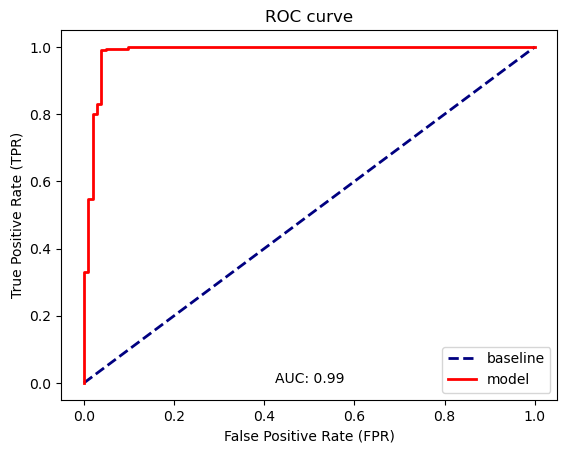

In [129]:
# olots the ROC curve using predicted probabilities for the shorter year than Earth class
plot_roc(y_test, lm.predict_proba(X_test)[:,1])

**3.5. Create a confusion matrix using the confusion_matrix_visual() function from the ml_utils.classification module.**

To round out the model evaluation, I've used the confusion_matrix_visual() function from ml_utils.classification. The purpose of the matrix is to provide a breakdown of the model's predictions compared to the actual classifications to help identify correct and incorrect predictions. The resulting confusion matrix revealed 204 True postitives (planets correctly classified as having shorter yrs. than Earth), 98 True negatives (planets correctly classified as having >= yr. length than Earth), 5 False positives (planets incorrectly classified as having shorter yrs. than Earth), and 2 False negatives (planets incorrectly classified as having >= yr. length than Earth). The low number of false postives/negatives suggests that the model is highly accurate, with very few misclassifications. In sum, this confusion matrix reinforces the strong performance observed in the earlier metrics like accuracy, precision, recall, ROC and AUC, confirming that the model reliably distinguishes between the 2 classifciations based on the selected features. 

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Actual', ylabel='Model Prediction'>

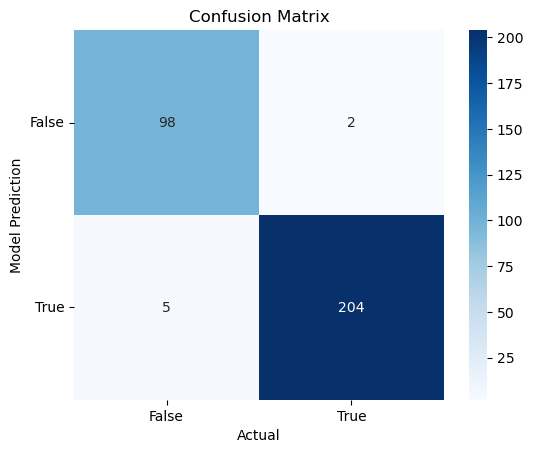

In [132]:
# creates confusion matrix viz. with labeled classes
# False = Planets w/ years >= Earth's 
# True = Planets w/ shorter years than Earth
confusion_matrix_visual(y_test, y_pred, class_labels = ["False", "True"])